# Image Denoiser using 2-layer

In [1]:
import os
import skimage
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [2]:
model_file = "actual_ae_undersampled_model.h5"
folder_path = "data/undersampled_pairs"
num_samples = 2000
image_dims = (128, 128)

In [3]:
def pretty_print(data, n=10):
    plt.figure(figsize=(2 * n, 2))
    for i in range(1, n+1):
        ax = plt.subplot(1, n, i)
        plt.imshow(data[i].reshape(image_dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [4]:
x = np.ndarray((num_samples, image_dims[0], image_dims[1]))
y = np.ndarray((num_samples, image_dims[0], image_dims[1]))
for i in range(num_samples):
    x[i] = skimage.io.imread("{}/f_fbp/{}.tif".format(folder_path, i))
    y[i] = skimage.io.imread("{}/f_true/{}.tif".format(folder_path, i))
    
# Normalize values
x = x.astype('float32') / 255.
y = y.astype('float32') / 255.

# Desired shape for keras is (n_samples, x, y, n_channels)
x = np.reshape(x, (len(x), image_dims[0], image_dims[1], 1))
y = np.reshape(y, (len(y), image_dims[0], image_dims[1], 1))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [6]:
y_train.shape

(1800, 128, 128, 1)

In [7]:
y_test.shape

(200, 128, 128, 1)

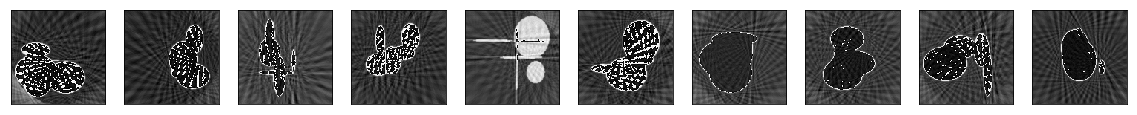

In [8]:
pretty_print(x_test)

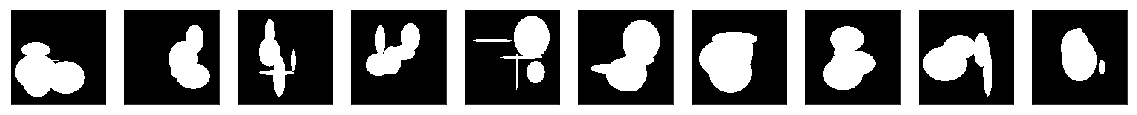

In [9]:
pretty_print(y_test)

In [10]:
input_img = Input(shape=(128, 128, 1)) # x, y, n_channels

# Model Architecture
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Define the model checkpoint
filepath = model_file
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
#                 validation_data=(x_test, y_test),
                callbacks=callbacks_list
               )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1800/1800 [==============================] - 90s 50ms/step - loss: 0.5925

Epoch 00001: loss improved from inf to 0.59254, saving model to actual_ae_undersampled_model.h5
Epoch 2/100
1800/1800 [==============================] - 83s 46ms/step - loss: 0.4575

Epoch 00002: loss improved from 0.59254 to 0.45746, saving model to actual_ae_undersampled_model.h5
Epoch 3/100
1800/1800 [==============================] - 82s 45ms/step - loss: 0.2957

Epoch 00003: loss improved from 0.45746 to 0.29567, saving model to actual_ae_undersampled_model.h5
Epoch 4/100
1800/1800 [==============================] - 81s 45ms/step - loss: 0.2101

Epoch 00004: loss improved from 0.29567 to 0.21011, saving model to actual_ae_undersampled_model.h5
Epoch 5/100
1800/1800 [==============================] - 82s 45ms/step - loss: 0.1999

Epoch 00005: loss improved from 0.21011 to 0.19985, saving model to actual_ae_undersampled_model.h5
Epoch 6/100
1800/1800

In [13]:
# If the execution is interrupted, change this
interrupted = False
if interrupted:
    new_model = load_model(model_file)
    predicted_y = new_model.predict(x_test)
else:
    predicted_y = autoencoder.predict(x_test)

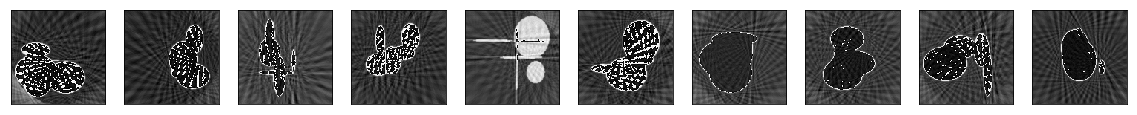

In [14]:
pretty_print(x_test)

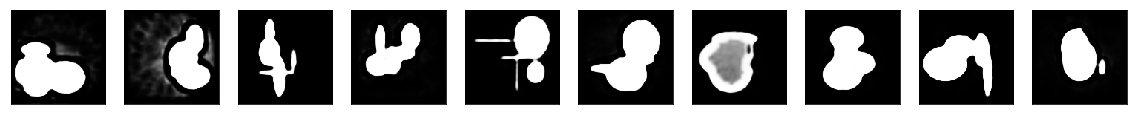

In [15]:
pretty_print(predicted_y)

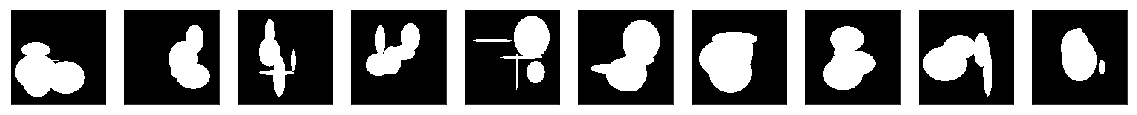

In [16]:
pretty_print(y_test)

In [17]:
psnr = []
ssim = []
wang = [] # Z. Wang et al., 2004
for i in range(len(x_test)):
    psnr.append(skimage.measure.compare_psnr(y_test[i], x_test[i]))
    ssim.append(skimage.measure.compare_ssim(y_test[i].reshape(128, 128), x_test[i].reshape(128, 128)))
    wang.append(skimage.measure.compare_ssim(
        y_test[i].reshape(128, 128), 
        x_test[i].reshape(128, 128),
        gaussian_weights=True,
        sigma=1.5,
        use_sample_covariance=False
    ))
print("PSNR is {:.2f}".format(np.mean(psnr)))
print("Generic SSIM is {:.2%}".format(np.mean(ssim)))
print("Wang SSIM is {:.2%}".format(np.mean(wang)))

PSNR is 8.02
Generic SSIM is 4.65%
Wang PSNR is 4.84%


In [18]:
psnr = []
ssim = []
wang = [] # Z. Wang et al., 2004
for i in range(len(x_test)):
    psnr.append(skimage.measure.compare_psnr(y_test[i], predicted_y[i]))
    ssim.append(skimage.measure.compare_ssim(y_test[i].reshape(128, 128), predicted_y[i].reshape(128, 128)))
    wang.append(skimage.measure.compare_ssim(
        y_test[i].reshape(128, 128), 
        predicted_y[i].reshape(128, 128),
        gaussian_weights=True,
        sigma=1.5,
        use_sample_covariance=False
    ))
print("PSNR is {:.2f}".format(np.mean(psnr)))
print("Generic SSIM is {:.2%}".format(np.mean(ssim)))
print("Wang SSIM is {:.2%}".format(np.mean(wang)))

PSNR is 22.67
Generic SSIM is 87.91%
Wang PSNR is 87.47%


In [72]:
def pretty_print_t(data, title, n=10):
    plt.figure(figsize=(2 * n, 2))
    for i in range(1, n+1):
        ax = plt.subplot(1, n, i)
        plt.imshow(data[i][0].reshape(image_dims))
        plt.gray()
        ax.set_title(title.format(data[i][1]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

PSNR is 24.96
Generic SSIM is 97.39%


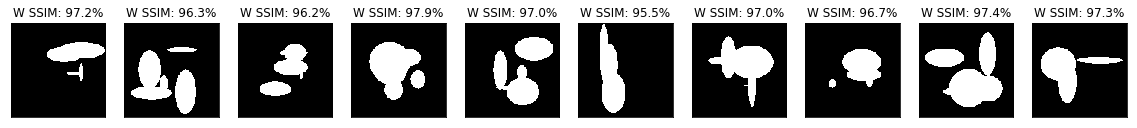

In [74]:
psnr = []
ssim = []
wang = [] # Z. Wang et al., 2004
for i in range(len(x_test)):
    psnr.append(skimage.measure.compare_psnr(y_test[i], decoded_imgs[i]))
    ssim.append(skimage.measure.compare_ssim(y_test[i].reshape(128, 128), decoded_imgs[i].reshape(128, 128)))
    wang.append((y_test[i].reshape(128, 128), skimage.measure.compare_ssim(
        y_test[i].reshape(128, 128), 
        decoded_imgs[i].reshape(128, 128),
        gaussian_weights=True,
        sigma=1.5,
        use_sample_covariance=False
    )))
print("PSNR is {:.2f}".format(np.mean(psnr)))
print("Generic SSIM is {:.2%}".format(np.mean(ssim)))
# print("Wang PSNR is {:.2%}".format(np.mean(wang)))
pretty_print_t(wang, "W SSIM: {:.1%}")